In [ ]:
!nvidia-smi

In [ ]:
!pip install -q -U progressbar2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import  Model
import os
from math import log2
import time
from skimage import  color, io
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from keras.callbacks import *
from IPython import display
from IPython.display import clear_output
import shutil
import progressbar

matplotlib.use('Agg')
plt.ioff()

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE= 16
EPOCHS = 30
PRETRAIN_EPOCHS = 50
IMG_SIZE = 128
OUTPUT_CHANNELS = 2
LAMBDA = 0.005

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
shutil.copy("/content/drive/My Drive/VCS Project/Train.zip", ".")
!unzip -q Train.zip
!rm Train.zip

In [ ]:
shutil.copy("/content/drive/My Drive/VCS Project/Val.zip", ".")
!unzip -q Val.zip
!rm Val.zip

In [ ]:
def convert2lab(img):
  srgb_pixels = tf.reshape(img, [-1, 3])
  
  linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
  exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
  rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
  rgb_to_xyz = tf.constant([
      #    X        Y          Z
      [0.412453, 0.212671, 0.019334], # R
      [0.357580, 0.715160, 0.119193], # G
      [0.180423, 0.072169, 0.950227], # B
  ])
  xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)
 
# https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
  xyz_normalized_pixels = tf.multiply(xyz_pixels, [1/0.950456, 1.0, 1/1.088754])
 
  epsilon = 6/29
  linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
  exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
  fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4/29) * linear_mask + (xyz_normalized_pixels ** (1/3)) * exponential_mask
 
  # convert to lab
  fxfyfz_to_lab = tf.constant([
      #  l       a       b
      [  0.0,  500.0,    0.0], # fx
      [116.0, -500.0,  200.0], # fy
      [  0.0,    0.0, -200.0], # fz
  ])
  lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])
 
  return tf.reshape(lab_pixels, tf.shape(img))

def convert2rgb(lab):
  lab_pixels = tf.reshape(lab, [-1, 3])
# https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
  # convert to fxfyfz
  lab_to_fxfyfz = tf.constant([
      #   fx      fy        fz
      [1/116.0, 1/116.0,  1/116.0], # l
      [1/500.0,     0.0,      0.0], # a
      [    0.0,     0.0, -1/200.0], # b
  ])
  fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

  # convert to xyz
  epsilon = 6/29
  linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
  exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
  xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

    # denormalize for D65 white point
  xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

      
  xyz_to_rgb = tf.constant([
      #     r           g          b
      [ 3.2404542, -0.9692660,  0.0556434], # x
      [-1.5371385,  1.8760108, -0.2040259], # y
      [-0.4985314,  0.0415560,  1.0572252], # z
  ])
  rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
  # avoid a slightly negative number messing up the conversion
  rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
  linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
  exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
  srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1/2.4) * 1.055) - 0.055) * exponential_mask

  return tf.reshape(srgb_pixels, tf.shape(lab))


In [ ]:
def resize_with_ratio(img, size):
  w, h = tf.shape(img)[0], tf.shape(img)[1]
 
  new_height = h * size // tf.minimum(w, h)
  new_width = w * size // tf.minimum(w, h)
  
  img = tf.image.resize(img, [new_width, new_height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img
 
def center_crop(img, size):
  w, h = tf.shape(img)[0], tf.shape(img)[1]
  x = (w - IMG_SIZE)//2
  y = (h - IMG_SIZE)//2
  img = tf.image.crop_to_bounding_box(img, x, y, IMG_SIZE, IMG_SIZE)
  return img
 
def normalise(lab_imgs):
  imgs = tf.reshape(lab_imgs, [-1, 3])
  normalised = (imgs / [50.0, 110.0, 110.0] ) - [1.0, 0.0, 0.0]
  return tf.reshape(normalised, tf.shape(lab_imgs))

def denormalise(lab_imgs):
  imgs = tf.reshape(lab_imgs, [-1, 3])
  unormalised = (imgs + [1.0, 0.0, 0.0]) * [50.0, 110.0, 110.0]
  return tf.reshape(unormalised, tf.shape(lab_imgs))

 
def data_augmentation(img):
  img = tf.image.random_flip_left_right(img)
  return img


def post_process(L, AB, rescale=False):
  image_lab = tf.concat([L, AB], axis=-1)
  image_lab = denormalise(image_lab)
  img_rgb = convert2rgb(image_lab)
  if rescale:
    img_rgb = img_rgb*255.0

  return img_rgb

In [ ]:
def load(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, dtype=tf.float32)/255.0
  return img
 
def load_image_train(file_path):
  img = load(file_path)
  img = tf.image.random_flip_left_right(img)
  lab_img = convert2lab(img)
  lab_img = normalise(lab_img)
  L = lab_img[:,:,0][..., tf.newaxis]
  AB = tf.stack([lab_img[:,:,1], lab_img[:,:,2]], axis=-1)
  return L, AB, file_path
 
#load an image and cretes the couple (L, RGB)
def load_image_test(file_path):
  #load image as RGB
  img = load(file_path)
  #Convert the image to LAB Space
  lab_img = convert2lab(img)
  #Nomalise the values so that they are in the range [-1, -1]
  lab_img = normalise(lab_img)
  #Extract the L channel
  L = lab_img[:,:,0][..., tf.newaxis]
  return L, img, file_path

AUTOTUNE = tf.data.experimental.AUTOTUNE
 
train_dataset = tf.data.Dataset.list_files('/content/Train/*.jpg')
                                              
train_dataset = train_dataset.shuffle(BUFFER_SIZE)\
                            .map(load_image_train, num_parallel_calls=AUTOTUNE)\
                            .batch(BATCH_SIZE)\
                            .prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.list_files('/content/Val/*.jpg', shuffle=False)
                                              
val_dataset = val_dataset.map(load_image_test)\
                          .batch(BATCH_SIZE)\
                          .prefetch(AUTOTUNE)

In [ ]:
class ICNR(tf.keras.initializers.Initializer):
  
    def __init__(self, initializer, scale=1):
      self.scale = scale
      self.initializer = initializer

    def __call__(self, shape, dtype):
      shape = list(shape)
      if self.scale == 1:
          return self.initializer(shape)

      new_shape = shape[:3] + [shape[3] // (self.scale ** 2)]
      x = self.initializer(new_shape, dtype)
      x = tf.transpose(x, perm=[2, 0, 1, 3])
      x = tf.image.resize(x, size=(shape[0] * self.scale, shape[1] * self.scale),
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      x = tf.nn.space_to_depth(x, block_size=self.scale)
      x = tf.transpose(x, perm=[1, 2, 0, 3])

      return x
    def get_config(self):
      return {"scale": self.scale, "initilizer": self.initializer}

class PixelShuffle_ICNR(Layer):
  def __init__(self, upsampling_factor=2, **kwargs):
    self.upsampling_factor = upsampling_factor
    super(PixelShuffle_ICNR, self).__init__(**kwargs)
  
  def build(self, input_shape):
    filters = input_shape[-1]*(self.upsampling_factor**2)/2
    self.conv = Conv2D(filters, kernel_size=(1, 1),
                       kernel_initializer=ICNR(tf.keras.initializers.GlorotUniform(),
                                               scale=self.upsampling_factor))
    self.pixel_shuffle = Lambda(lambda x: self._pixel_shuffle(x))
    self.replicate_pad = Lambda(lambda x: self._replicate_pad(x, padding=(1, 0, 1, 0)))
    self.avg_polling =  AveragePooling2D(pool_size=(2,2), strides=(1, 1))
  
  def call(self, input):
    x = self.conv(input)
    x = self.pixel_shuffle(x)
    x = self.replicate_pad(x)
    x = self.avg_polling(x)

    return tf.keras.activations.relu(x)

  def _pixel_shuffle(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

  def _replicate_pad(self, input, padding=(1, 1, 1, 1)):
    padding_left, padding_right = padding[0], padding[1]
    padding_top, padding_bottom = padding[2], padding[3]
    return tf.pad(input, [[0,0], [padding_top, padding_bottom],
                          [padding_left, padding_right], [0,0] ], 'SYMMETRIC')


tf.keras.utils.get_custom_objects().update({'PixelShuffle_ICNR': PixelShuffle_ICNR})

In [ ]:
class Resize_Conv2D(Layer):
  def __init__(self, filters, kernel, stride, use_bias=False, upsampling_factor=2):
        self.filters = filters
        self.kernel = kernel
        self.stride = stride
        self.use_bias = use_bias
        self.upsampling_factor = upsampling_factor
        
        super(Resize_Conv2D, self).__init__()

  def build(self, input_shape):
    initializer = tf.random_normal_initializer(0., 0.02)
    pad = self.kernel // 2

    self.paddings = tf.constant([[0, 0], [pad, pad],[pad, pad], [0, 0]])
    self.conv2d = Conv2D(self.filters, self.kernel, self.stride, use_bias=self.use_bias,
                         padding='valid', kernel_initializer=initializer)
  def call(self, inputs):
      new_h = inputs.shape[1] * self.upsampling_factor
      new_w = inputs.shape[2] * self.upsampling_factor

      x = tf.image.resize(inputs, [new_h, new_w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      x = tf.pad(x, self.paddings, mode='REFLECT')
      x = self.conv2d(x)
      return x 

In [ ]:
def down_sample(input, filters, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  x = Conv2D(filters, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(input)
  if apply_batchnorm:
    x = BatchNormalization()(x,training=True)
  x = LeakyReLU(alpha=0.2)(x)

  return x

def up_sample(input, skip, filters, resize_conv=False, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  if not resize_conv:
    x = Conv2DTranspose(filters, 4, strides=2, padding='same', 
                        kernel_initializer=initializer, use_bias=False)(input)
  else:
    x = Resize_Conv2D(filters, 3, 1)(input)
  x = BatchNormalization()(x,training=True)
  if apply_dropout:
    x = Dropout(0.5)(x, training=True)
  x = ReLU()(x)
  x = Concatenate()([x, skip])

  return x

In [ ]:
def define_generator(input_shape, output_channel, n_blocks):
  initializer = tf.random_normal_initializer(0., 0.02)
  inputs = Input(input_shape)

  min_filters = 64
  
  x = down_sample(inputs, 64, apply_batchnorm=False)
  skips = [x]
  nb_filters = [min_filters]
  for i in range(1, n_blocks - 1):
    filters = min_filters * min(8, (2 ** i))
    x = down_sample(x, filters)
    skips.append(x)
    nb_filters.append(filters)
  
  x = down_sample(x, 512, apply_batchnorm=False)

  nb_filters = reversed(nb_filters)
  skips = reversed(skips)
  for i, (filters, skip) in enumerate(zip(nb_filters, skips)):
    apply_dp = i < 2
    x = up_sample(x, skip, filters, apply_dropout=apply_dp, resize_conv=True)

  x = Resize_Conv2D(output_channel, 3, 1, use_bias=True)(x)
  output = Activation('tanh')(x)
  
  return Model(inputs=inputs, outputs=output)

In [ ]:
def define_discriminator(input_shape, target_shape):
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = Input(shape=input_shape, name='input_image')
  tar = Input(shape=target_shape, name='target_image')

  x = Concatenate()([inp, tar])

  x = down_sample(x, 64, apply_batchnorm=False)
  x = down_sample(x, 128)
  x = down_sample(x, 256)

  x = ZeroPadding2D()(x)
  x = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)

  x = BatchNormalization()(x, training=True)
  x = LeakyReLU()(x)
  x = ZeroPadding2D()(x)

  last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

  return Model(inputs=[inp, tar], outputs=last)

In [ ]:
def feature_extractor_model(input_shape):
  feature_layers = ['block1_conv1',
                    'block1_conv2',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1',
                    'block5_conv2',
                    'block5_conv3',
                    'block5_conv4']


  vgg_model = tf.keras.applications.VGG19(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
  vgg_model.trainable = False

  outputs = [vgg_model.get_layer(layer).output for layer in feature_layers]
  
  extractor = tf.keras.Model(vgg_model.input, outputs)
  return extractor

@tf.function
def feature_loss(feature_extractor, input_l, fake_ab, real_ab):
  feature_weights = [10, 10, 7, 7, 10, 10, 10, 10]

  fake_img = post_process(input_l, fake_ab, rescale=True)
  real_img = post_process(input_l, real_ab, rescale=True)

  fake_preprocessed = tf.keras.applications.vgg19.preprocess_input(fake_img)
  real_preprocessed = tf.keras.applications.vgg19.preprocess_input(real_img)

  fake_features = feature_extractor(fake_preprocessed)
  real_features = feature_extractor(real_preprocessed)

  loss = tf.add_n([tf.reduce_mean(tf.abs(real-fake))*w
                        for real, fake, w in zip(real_features, fake_features, feature_weights)])
  return loss

In [ ]:
def generate_images(dataset, generator, save_path):
  
  def generate(dataset, generator):
    batch_shape = tf.data.experimental.get_structure(dataset)[1].shape
    fake_images = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 3))
    inputs = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 1))
    real_images = np.empty_like(fake_images)

    for Ls, real, _ in dataset:
      fake_ABs = generator.predict(Ls)

      fake_RGBs = post_process(Ls, fake_ABs)

      fake_images = np.append(fake_images, fake_RGBs, axis=0)
      inputs = np.append(inputs, Ls, axis=0)
      real_images = np.append(real_images, real, axis=0)

    return inputs, real_images, fake_images 

  fig =  plt.figure(dpi=300, figsize=(30,30), constrained_layout=False)

  inputs, real_images, fake_images = generate(dataset, generator)
  num_images = fake_images.shape[0]

  grid = ImageGrid(fig, 141,  #
                     nrows_ncols=(num_images, 3),
                     axes_pad=0.01,
                     label_mode="1",
                     )

  title = ['Input','Real', 'Fake']

  for n, (L, real, fake) in enumerate(zip(inputs, real_images, fake_images)):
    input = (L[..., 0] + 1.0)/2.0
    display_list = [input , real, fake]

    for i in range(3):
      ax = grid[n*3 + i]
      ax.axis('off')
      if n == 0:
        ax.set_title(title[i])
      if i == 0:
        ax.imshow(display_list[i], cmap='gray', aspect='auto')
      else:
        ax.imshow(display_list[i], aspect='auto')
      
  fig.savefig(save_path, bbox_inches='tight', aspect='auto')

# Pretraining

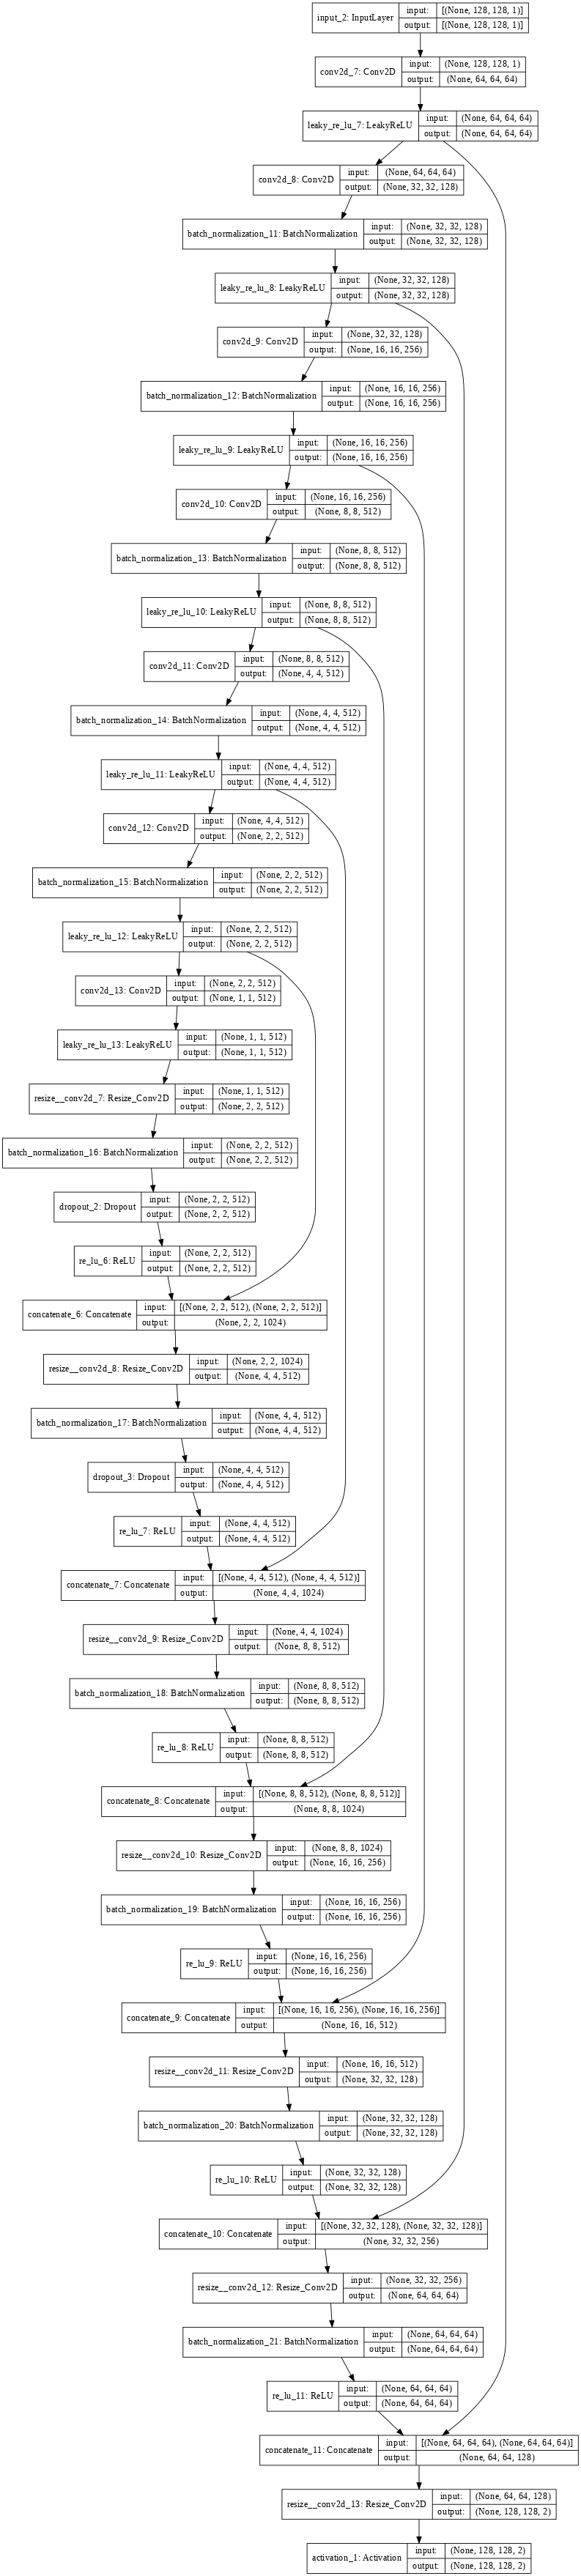

In [ ]:
generator = define_generator([IMG_SIZE, IMG_SIZE, 1], OUTPUT_CHANNELS, int(log2(IMG_SIZE)))
tf.keras.utils.plot_model(generator, dpi=64, show_shapes=True)

In [ ]:
import datetime
log_dir="logs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
generator = define_generator([IMG_SIZE, IMG_SIZE, 1], OUTPUT_CHANNELS, int(log2(IMG_SIZE)))
optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)
feature_extractor = feature_extractor_model((IMG_SIZE, IMG_SIZE, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
checkpoint_dir = '/content/drive/My Drive/VCS Project/pretrained'
pretrianed_checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 generator=generator,
                                 step=tf.Variable(0))
pretrianed_manager = tf.train.CheckpointManager(pretrianed_checkpoint, checkpoint_dir, max_to_keep=8)

In [ ]:
def pretrain_generator(train_ds, epochs):

  widgets=[
      progressbar.Bar(marker='=', left='[', right=']'),
      progressbar.widgets.SimpleProgress(),
      ' - ', progressbar.Timer(),'',
      '-', progressbar.AdaptiveETA(), ''
  ]

  @tf.function
  def train_step(input, target, epoch):
    with tf.GradientTape() as gen_tape:
      gen_output = generator(input, training=True)
      loss = feature_loss(feature_extractor, input, gen_output, target)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)
  
    optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    with summary_writer.as_default():
      tf.summary.scalar('loss', loss, step=epoch)
  
  print('Starting pretraining generator...')
  
  pretrianed_checkpoint.restore(pretrianed_manager.latest_checkpoint)
  if pretrianed_manager.latest_checkpoint:
    print("Restored from {}".format(pretrianed_manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  step = int(pretrianed_checkpoint.step)
  iters = train_ds.cardinality().numpy()
  for epoch in range(step, epochs):

    print(f'Epoch: {epoch}')
    # Train
    with progressbar.ProgressBar(max_value=iters, widgets=widgets) as pbar:
      for n, (input_image, target) in train_ds.enumerate():
    
        train_step(input_image, target, epoch)
        pbar.update(n.numpy())
    print('')
    
    path = f'/content/drive/My Drive/VCS Project/pretrained/samples/sample_{epoch + 1}.jpg'
    generate_images(val_dataset, generator, path);

    pretrianed_checkpoint.step.assign_add(1)
    if epoch >= 10:
      pretrianed_manager.save()
    

    clear_output()             

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
pretrain_generator(train_dataset, PRETRAIN_EPOCHS)

In [ ]:
#pretrianed_checkpoint.restore('/content/drive/My Drive/VCS Project/pretrained/ckpt-39')

# Adversarial Training

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()
feature_extractor = feature_extractor_model((IMG_SIZE, IMG_SIZE, 3))
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
generator = define_generator([IMG_SIZE, IMG_SIZE, 1], OUTPUT_CHANNELS, int(log2(IMG_SIZE)))
discriminator = define_discriminator([IMG_SIZE, IMG_SIZE, 1], [IMG_SIZE, IMG_SIZE, 2])

In [ ]:
generator.load_weights('/content/drive/My Drive/VCS Project/pretrained/').assert_consumed()

In [ ]:
def generator_loss(disc_generated_output, input, gen_output, target):
  gan_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
 
  f_loss = feature_loss(feature_extractor, input, gen_output, target)
  
  total_gen_loss = gan_loss + LAMBDA*f_loss

  return total_gen_loss, gan_loss, f_loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
 
  generated_loss = loss_object(tf.ones_like(disc_generated_output)*-1.0, disc_generated_output)
 
  total_disc_loss = real_loss + generated_loss
 
  return total_disc_loss


In [ ]:
import datetime
log_dir="logs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image)

    disc_real_output = discriminator([input_image, target])
    disc_generated_output = discriminator([input_image, gen_output])
 
    gen_total_loss, gen_gan_loss, f_loss = generator_loss(disc_generated_output, input_image, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
 
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
 
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
 
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_f_loss', f_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/VCS Project/checkpoints'
checkpoints = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 step=tf.Variable(0))
manager = tf.train.CheckpointManager(checkpoints, checkpoint_dir, max_to_keep=8)

In [ ]:
import datetime
from datetime import timedelta
import progressbar

widgets=[
    progressbar.Bar(marker='=', left='[', right=']'),
    progressbar.widgets.SimpleProgress(),
    ' - ', progressbar.Timer(), '',
    '-', progressbar.AdaptiveETA(), ''
]
def fit(train_ds, epochs):
  checkpoints.restore(manager.latest_checkpoint)

  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  step = int(checkpoints.step)
  
  for epoch in range(step, epochs):
    start = time.time()
    iters = train_ds.cardinality().numpy()
 
    print(f'Epoch: {epoch + 1}')
    # Train
    with progressbar.ProgressBar(max_value=iters, widgets=widgets) as pbar:
      for n, (input_image, target, _) in train_ds.enumerate():
    
        train_step(input_image, target, epoch)
        pbar.update(n.numpy())

    path = f'/content/drive/My Drive/VCS Project/samples/sample_{epoch + 1}.jpg'
    generate_images(val_dataset, generator, path);

    checkpoints.step.assign_add(1)
    #saving (checkpoint) the model after 10 epochs
    if epoch >= 10:
      manager.save()
    
    clear_output()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
fit(train_dataset, EPOCHS)

In [ ]:
print(manager.latest_checkpoint)

/content/drive/My Drive/VCS Project/checkpoints/ckpt-30


In [ ]:
checkpoints.restore('/content/drive/My Drive/VCS Project/checkpoints/ckpt-21')

In [ ]:
shutil.copy("/content/drive/My Drive/VCS Project/Test.zip", ".")
!unzip -q Test.zip
!rm Test.zip

In [ ]:
generator = tf.keras.models.load_model('/content/drive/My Drive/VCS Project/Best Model/')

In [ ]:
test_paths = tf.data.Dataset.list_files('/content/Test/*.jpg', shuffle=False)
test_dataset = test_paths.map(load_image_test, deterministic=True)\
                          .batch(BATCH_SIZE)\
                          .prefetch(AUTOTUNE)

for Ls, _, file_paths in test_dataset:

  fake_ABs = generator.predict(Ls)

  fake_LABs = tf.concat([Ls, fake_ABs], axis=-1)
  fake_LABs = denormalise(fake_LABs)
  fake_RGBs = convert2rgb(fake_LABs)

  for (fake, file_path) in zip(fake_RGBs, file_paths):
    fake_img = tf.image.convert_image_dtype(fake, dtype=tf.uint8)
    img = tf.image.encode_jpeg(fake_img)

    filename = os.path.basename(file_path.numpy())
    save_path= f'/content/drive/My Drive/VCS Project/examples/{filename.decode("utf-8")}'
    tf.io.write_file(save_path, img)